In [1]:
# You must install this system library to make pylibdmtx work
# sudo apt-get install libdmtx0b

In [2]:
from PIL import Image
import pylibdmtx.pylibdmtx
import albumentations
import numpy as np
import pandas as pd

In [3]:
encoded = pylibdmtx.pylibdmtx.encode('Máme rádi papoušky'.encode('utf8'))
img = Image.frombytes('RGB', (encoded.width, encoded.height), encoded.pixels)
img.save('dmtx.png')
decoded = pylibdmtx.pylibdmtx.decode(Image.open('dmtx.png'))
decoded[0].data.decode("utf8")

'Máme rádi papoušky'

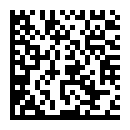

In [4]:
img

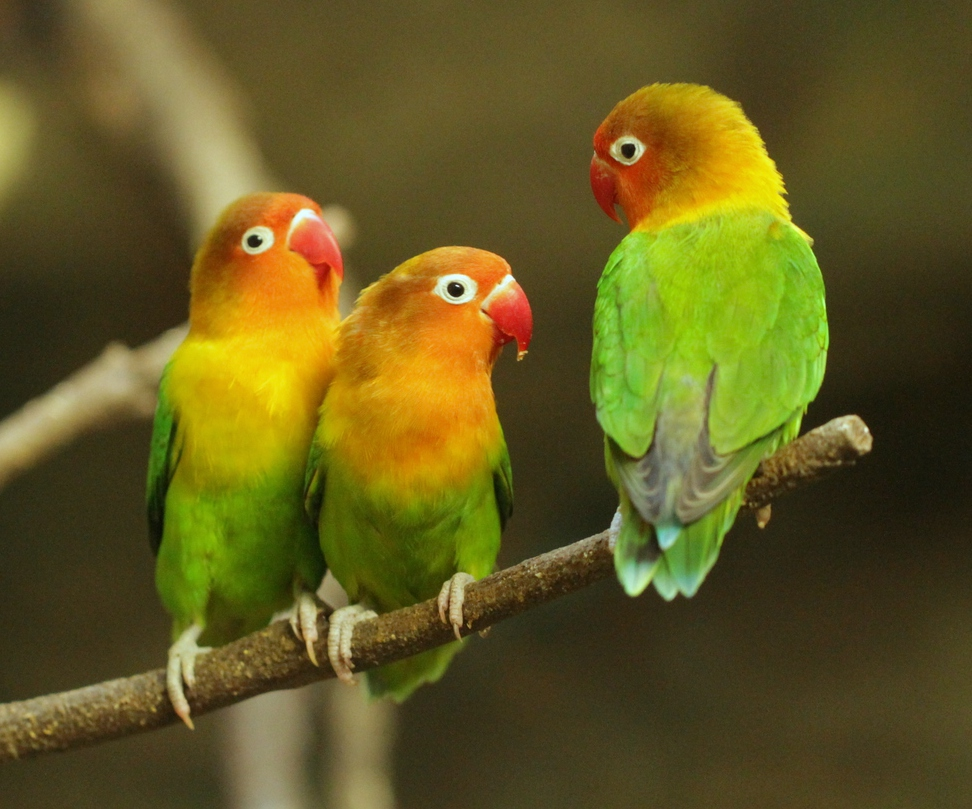

In [5]:
image = Image.open("parrot.jpg")
image

In [6]:
transform = albumentations.Compose([
    albumentations.RandomCrop(width=256, height=256),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightnessContrast(p=0.2),
])

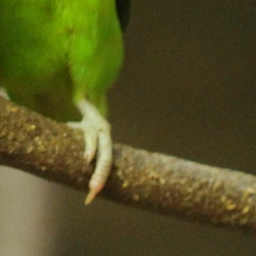

In [7]:
transformed = transform(image=np.array(image))
transformed_image = transformed["image"]
Image.fromarray(transformed_image)

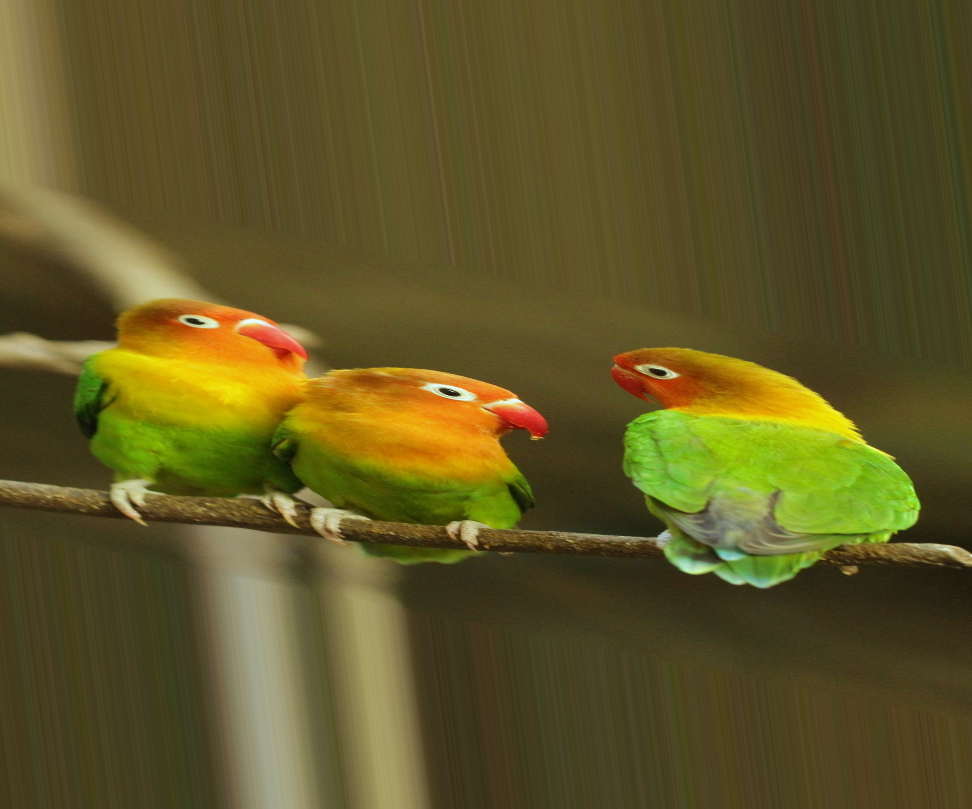

In [8]:
el_transform = albumentations.ElasticTransform(always_apply=True, alpha_affine=200, border_mode=1)
el_transformed = el_transform(image=np.array(image))
el_transformed_image = el_transformed["image"]
Image.fromarray(el_transformed_image)

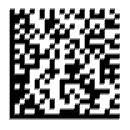

In [9]:
blur_transform = albumentations.MotionBlur(always_apply=True)
blur_transformed = blur_transform(image=np.array(img))
blur_transformed_image = blur_transformed["image"]
Image.fromarray(blur_transformed_image)

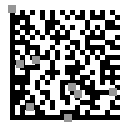

In [10]:
drop_transform = albumentations.CoarseDropout(always_apply=True, fill_value=150)
drop_transformed = drop_transform(image=np.array(img))
drop_transformed_image = drop_transformed["image"]
Image.fromarray(drop_transformed_image)

In [67]:
import conv_ae
import datamatrix_provider as dmp

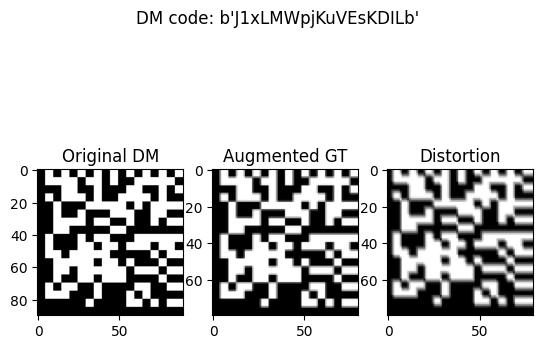

In [68]:
dm_provider_example = dmp.DataMatrixProvider(visualize=True)
dm_generate_example, dm_size_example, dm_mode_example, dm_mode_opts_example, dm_const_example = dm_provider_example.init_dm_provider(library="pylibdmtx", pylibdmtx_params={})
dm_clean_example, dm_augm_example, dm_text_example = dm_generate_example()

In [87]:
def preprocess(image: np.ndarray) -> np.ndarray:
    if image.ndim == 2:
        new_shape = (1,) + image.shape
        image = image.reshape(new_shape)
    return image.astype(np.float32) / 255

In [88]:
import random

def create_dataset(num_samples, seed):
    random.seed(seed)
    dataset = []
    dm_provider = dmp.DataMatrixProvider()
    for _ in range(num_samples):
        dm_clean, dm_augm, dm_text = next(dm_provider)[0]
        dataset.append((dm_clean, dm_augm, dm_text))
    return pd.DataFrame(dataset, columns=["target", "corrupted", "text"])

In [89]:
import torch

class MyMapDataset(torch.utils.data.Dataset):
    def __init__(self, dataset) -> None:
        super().__init__()
        self.dataset = dataset

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, i: int) -> dict:
        return {"target": preprocess(self.dataset.iloc[i]["target"]),
                "corrupted": preprocess(self.dataset.iloc[i]["corrupted"])}

In [90]:
dataloader_valid = torch.utils.data.DataLoader(dataset=MyMapDataset(create_dataset(500, seed=0)), batch_size=64)
dataloader_test = torch.utils.data.DataLoader(dataset=MyMapDataset(create_dataset(500, seed=1)), batch_size=64)

In [91]:
class MyIterableDataset(torch.utils.data.IterableDataset):
    def __init__(self, dm_provider: dmp.DataMatrixProvider) -> None:
        super().__init__()
        self.dm_provider = dm_provider

    def __iter__(self):
        while True:
            batch = next(self.dm_provider)
            for dm_target, dm_corrupt, dm_text in batch:
                yield {"target": preprocess(dm_target),
                       "corrupted": preprocess(dm_corrupt)}

In [92]:
dataloader_train = torch.utils.data.DataLoader(dataset=MyIterableDataset(dmp.DataMatrixProvider()), batch_size=64)

In [93]:
next(iter(dataloader_train))["target"].shape

torch.Size([64, 1, 80, 80])

In [94]:
import lightning.pytorch as pl

class LitAutoEncoder(pl.LightningModule):
    def __init__(self, autoencoder):
        super().__init__()
        self.autoencoder = autoencoder

    def training_step(self, batch, batch_idx):
        target = batch["target"]
        corrupted = batch["corrupted"]
        preds = self.autoencoder(corrupted)
        loss = torch.nn.functional.mse_loss(preds, target)
        self.log("train_loss", loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [95]:
autoencoder = LitAutoEncoder(conv_ae.ConvAutoencoder())
trainer = pl.Trainer(limit_train_batches=100, max_epochs=1)
trainer.fit(model=autoencoder, train_dataloaders=dataloader_train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type            | Params
------------------------------------------------
0 | autoencoder | ConvAutoencoder | 1.1 K 
------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
/home/kp/miniconda3/envs/dm-codes/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/kp/miniconda3/envs/dm-codes/lib/python3.9/site-packages/lightning/pytorch/utilities/data.py:105: UserWarning: Total lengt

Epoch 0:   1%|          | 1/100 [00:00<00:46,  2.12it/s, v_num=3]

/home/kp/miniconda3/envs/dm-codes/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s, v_num=3]


In [96]:
trainer.logged_metrics

{'train_loss': tensor(0.1494)}